In [21]:
import pandas as pd

from sklearn import model_selection
from sklearn import ensemble
from sklearn import pipeline
from sklearn import metrics
from feature_engine import imputation

import scikitplot as skplt

A base consiste em uma série de estatisticas de visualização de um canal ta twitch, a ideia é entender se apartir dessas métricas é possivel verificar se o usuário vai ser um usuário ativo ou não

In [5]:
df = pd.read_csv("../data/dados_pontos.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dtRef              2235 non-null   object 
 1   idCustomer         2235 non-null   object 
 2   Name               2235 non-null   object 
 3   qtdeRecencia       2235 non-null   float64
 4   freqDias           2235 non-null   int64  
 5   freqTransacoes     2235 non-null   int64  
 6   qtdListaPresença   2235 non-null   int64  
 7   qtdChatMessage     2235 non-null   int64  
 8   qtdTrocaPontos     2235 non-null   int64  
 9   qtdResgatarPonei   2235 non-null   int64  
 10  qtdPresençaStreak  2235 non-null   int64  
 11  pctListaPresença   2235 non-null   float64
 12  pctChatMessage     2235 non-null   float64
 13  pctTrocaPontos     2235 non-null   float64
 14  pctResgatarPonei   2235 non-null   float64
 15  pctPresençaStreak  2235 non-null   float64
 16  qtdePontosGanhos   2235 

In [6]:
features = df.columns[3:-1] # da terceira coluna até a penultima
target = "flActive"

É sempre necessário separar o modelo entre uma base de treino e uma base de teste, isso para garantir que o nosso modelo se adeque também a dados que nunca foram vistos, nesse caso utilizaremos a base de treino como 80% da base total, e a de teste como 20%

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features],
                                                                    df[target],
                                                                    random_state=42,
                                                                    test_size=0.2,
                                                                    stratify=df[target],)

print("Tx. resposta Train:", y_train.mean())
print("Tx. resposta Test:", y_test.mean())

Tx. resposta Train: 0.32550335570469796
Tx. resposta Test: 0.32662192393736017


Nossa base tem um problema, temos dados nulos na coluna "avgRecorrencia" possui dados nulos, precisamos substituir isso na nossa base de treino e de teste, para isso utilizaremos uma **pipeline**, dessa forma mantemos separadas nossas bases de teste e treino, e conseguimos simplificar o projeto

In [12]:
X_train.isna().sum()

qtdeRecencia           0
freqDias               0
freqTransacoes         0
qtdListaPresença       0
qtdChatMessage         0
qtdTrocaPontos         0
qtdResgatarPonei       0
qtdPresençaStreak      0
pctListaPresença       0
pctChatMessage         0
pctTrocaPontos         0
pctResgatarPonei       0
pctPresençaStreak      0
qtdePontosGanhos       0
qtdePontosGastos       0
qtdePontosSaldo        0
avgRecorrencia       810
dtype: int64

In [ ]:
imput_max = imputation.ArbitraryNumberImputer(arbitrary_number=999,
                                              variables=['avgRecorrencia'])

clf = ensemble.RandomForestClassifier(random_state=42)

params = {
    "n_estimators": [200,300,400,500],
    "min_samples_leaf":[10,20,50,100]
          }

grid = model_selection.GridSearchCV(clf,
                                    param_grid=params,
                                    scoring='roc_auc',
                                    n_jobs=-1)

model = pipeline.Pipeline([
    ('imput', imput_max),
    ('model', grid)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imput', ArbitraryNumberImputer(variables=['avgRecorrencia'])),
                ('model',
                 GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'min_samples_leaf': [10, 20, 50, 100],
                                          'n_estimators': [200, 300, 400, 500]},
                              scoring='roc_auc'))])

Quando é chamado model.fit(X, y), o pipeline irá:

1. Aplicar a imputação nos dados de treino
2. Fazer a busca em grade com validação cruzada para encontrar os melhores hiperparâmetros
3. Treinar o modelo final com os melhores parâmetros encontrados

Agora precisamos verificar se o nosso modelo está sendo efetivo

In [14]:
y_test_proba = model.predict_proba(X_test)
y_test_proba

array([[0.37281797, 0.62718203],
       [0.77822833, 0.22177167],
       [0.92272665, 0.07727335],
       [0.65415942, 0.34584058],
       [0.85537271, 0.14462729],
       [0.93282919, 0.06717081],
       [0.95708451, 0.04291549],
       [0.72241952, 0.27758048],
       [0.84190714, 0.15809286],
       [0.81005858, 0.18994142],
       [0.95459215, 0.04540785],
       [0.34120607, 0.65879393],
       [0.9394688 , 0.0605312 ],
       [0.92071203, 0.07928797],
       [0.19403141, 0.80596859],
       [0.63208527, 0.36791473],
       [0.65329396, 0.34670604],
       [0.08212753, 0.91787247],
       [0.62583258, 0.37416742],
       [0.41757036, 0.58242964],
       [0.51333262, 0.48666738],
       [0.81834532, 0.18165468],
       [0.72898996, 0.27101004],
       [0.7084482 , 0.2915518 ],
       [0.79284502, 0.20715498],
       [0.94748387, 0.05251613],
       [0.56265569, 0.43734431],
       [0.69046835, 0.30953165],
       [0.58309484, 0.41690516],
       [0.11926455, 0.88073545],
       [0.

In [16]:
df = pd.DataFrame({
    "flActive": y_test,
    "proba_modelo":y_test_proba[:,1]
})

df.to_excel("../data/dados_ks.xlsx", index=False)
#resultado real vs probabilidade do modelo

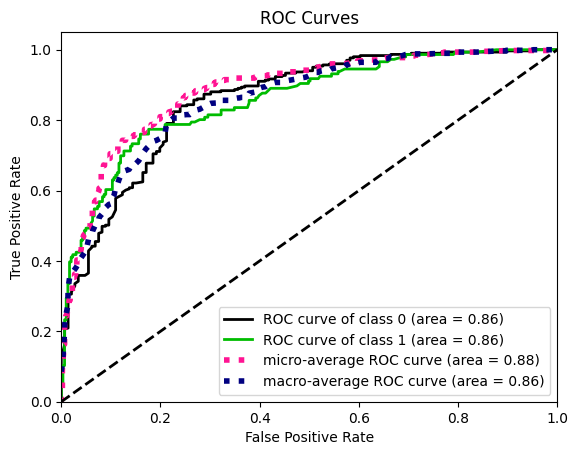

In [23]:
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_test,y_test_proba)
plt.show()


In [37]:
metrics.roc_auc_score(y_test,y_test_proba[:,1])
#a area da curva está muito boa

np.float64(0.8574841851363036)

O seguinte gráfico é uma métrica muito interessante de ser analizada, ela mede a quantidade que o meu modelo está ganahndo de simplesmente "jogar uma moeda" para definir os dados, quanto mais a linha colorida se distanciar da linha base melhor.
Essa análise ordena minhas probabilidades e calcula a porcentagem dos acertos, então pegando apenas 20% da base, o modelo já havia achado 50% de todos os inativos 

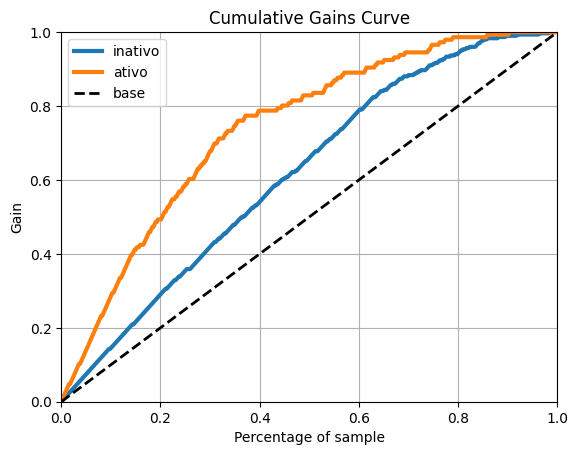

In [42]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_proba)
plt.legend(['inativo','ativo','base'])
plt.show()

O seguinte gráfico mostra então o quão superior o modelo é de chutar aleatóriamente.

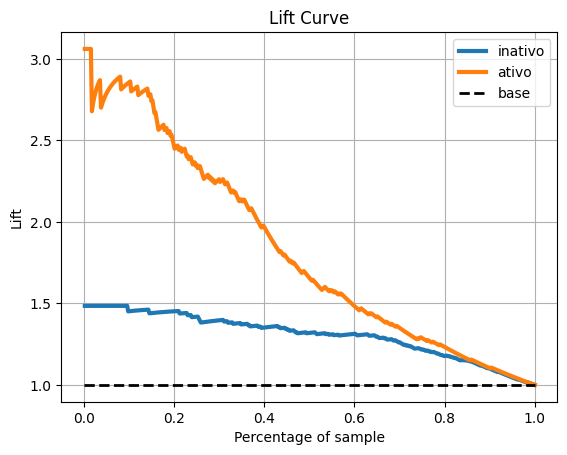

In [43]:
skplt.metrics.plot_lift_curve(y_test, y_test_proba)
plt.legend(['inativo','ativo','base'])
plt.show()